In [107]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import src as functions
import re
from nltk.tokenize import regexp_tokenize, word_tokenize, sent_tokenize
from sklearn.model_selection import train_test_split, cross_validate , GridSearchCV, cross_val_predict
from sklearn.pipeline import make_pipeline , Pipeline
from nltk import word_tokenize
from nltk.corpus import stopwords as sw
from sklearn.linear_model import LogisticRegression , SGDClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
import warnings
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
warnings.filterwarnings ("ignore")
%load_ext autoreload
%reload_ext autoreload 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
df = pd.read_csv('data/Labelled Yelp Dataset Edited.csv')
target = len(df.loc[df['Label'] == -1])
not_target = len(df.loc[df['Label'] == 1])
pd.set_option ('display.max_colwidth', None)            

In [49]:
print(f'''Number of targets: {target}
Percent of data target: {round(target / len(df),3)*100}
Number of rows: {len(df)}''')

Number of targets: 11154
Percent of data target: 10.0
Number of rows: 111798


There are 11154 fake reviews that make up 10 percent of the data. If we were to go ahead and classify everything as a real review, there would be a 90% accuracy rate. 

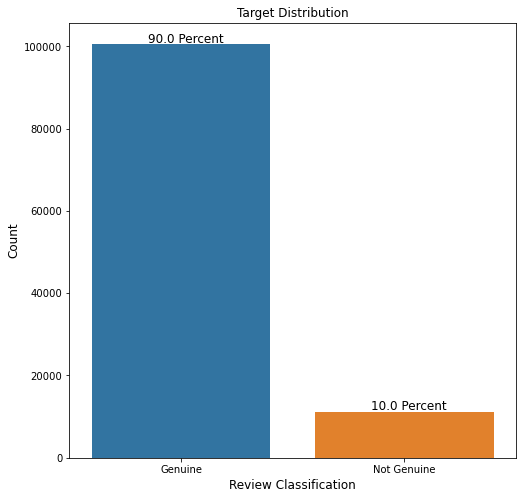

In [50]:
fig , ax = plt.subplots(figsize=(8,8))

sns.barplot(x=['Genuine','Not Genuine'],y=[not_target,target])
plt.text(0-.15,not_target+300,f'{round(not_target/(len(df)),2)*100} Percent',fontsize=12)
plt.text(1-.15,target+500,f'{round(target/(len(df)),2)*100} Percent',fontsize=12)
ax.set_title('Target Distribution',fontsize=12)
ax.set_xlabel('Review Classification',fontsize=12)
ax.set_ylabel('Count',fontsize=12);

In [51]:
pd.to_datetime(df['Date'])

0        2014-12-08
1        2013-05-16
2        2013-07-01
3        2011-07-28
4        2010-11-01
            ...    
111793   2013-03-29
111794   2013-02-13
111795   2012-11-09
111796   2012-10-13
111797   2012-09-13
Name: Date, Length: 111798, dtype: datetime64[ns]

In [52]:
df

,User_id,Product_id,Rating,Date,Review,Label
0,923,0,3,12/8/2014,The food at snack is a selection of popular Greek dishes. The appetizer tray is good as is the Greek salad. We were underwhelmed with the main courses. There are 4-5 tables here so it's sometimes hard to get seated.,-1
1,924,0,3,5/16/2013,"This little place in Soho is wonderful. I had a lamb sandwich and a glass of wine. The price shocked me for how small the serving was, but then again, this is Soho. The staff can be a little snotty and rude, but the food is great, just don't expect world-class service.",-1
2,925,0,4,7/1/2013,"ordered lunch for 15 from Snack last Friday. Â On time, nothing missing and the food was great. Â I have added it to the regular company lunch list, as everyone enjoyed their meal.",-1
3,926,0,4,7/28/2011,"This is a beautiful quaint little restaurant on a pretty street. Â If you're strolling through soho around lunchtime, this would be a great place to stop for a bite. I heard the reviews about the lamb sandwich, so I had to try it. I'm very happy that i did. Every single ingredient - from the bread to the onions and tomatoes, the lamb and the sauce - was delicious. These four stars are well deserved because of the tasty sandwich and great ambiance. Â I would recommend this place to anyone.",-1
4,927,0,4,11/1/2010,"Snack is great place for a Â casual sit down lunch- especially on a cold winter day. Â In many ways the restaurant mirrors the food- simple yet unique. Â The avgolemono soup was lemony perfection and the butter bean salad hearty yet light. Â The greek coffee is different...they sweeten it with honey which makes for an interesting thickness and sweet spice. I definitely plan on going back for dinner. Â If the small space doesn't suit you their sister restaurant Snack Taverna in the West Village is just as good, if not better...and more ""upscale"" with waiters who make you feel well taken care of.",-1
...,...,...,...,...,...,...
111793,67541,318,2,3/29/2013,"The chicken and waffles were great!!!. My friend got the cheese burger and fries. The fries were soggy and the burger was a frozen patty, which is unforgivable!!!",1
111794,69555,318,4,2/13/2013,"Delicious food, friendly service. Wish the portions were slightly larger on the dinner meal deal -- hmm, probably a good thing they aren't lol",1
111795,67575,318,5,11/9/2012,"The food here is SLAMMIN""!!! e I truly love when you try a restaurant for the first time and the workers/owners are all so happy you came! The service is really a major plus. I felt like I walked into my aunt's house or something. I've tried a few of the items on the menu but the standout by far would be the honey bbq wings. They are so sweet and tangy! I have not had wings that juicy and good in a very long time. The homemade baked good are equally stellar. I hate cheesecake, but the sweet potato cheesecake here changed my mind! The yellow cake with chocolate frosting, the lemon cake all hits! Any of the sides you choose for your meal will be well seasond and tasty! Wash it all down with a hal and half and you will be in heaven. I have not tried the breakfast and to be honest I am scared to do it. Grits, salmon cakes, waffles with nutella...These things could be a major wardrobe shrinker. I am very confident that when I do, it will be worth every calorie. Get yourself over there ASAP!!",1
111796,69556,318,5,10/13/2012,"I just moved to Brooklyn and was in search of that Chicken and Waffles combo I used to have back home in California. Â I've had tried plenty since I've moved to NY, but NONE compare to Napoleons!! Â I ordered the 4 mini waffles and wings dinner plate (substituting the wings for a leg and breast). Â The meat was juicy, mouth watering, and moist. Â The skin was crispy, crunchy, and extremely flavorful. Â The waffles we fluffy and covered in butter and powered sugar, with syrup on the side to smother at my will. Â SO, SO YUMMY! Â If that wasn't enough, my boyfriend ordered the Honey Barbeque Chick

In [53]:
df['Date'].sort_values(ascending=False)

89577    9/9/2014
89980    9/9/2014
73459    9/9/2014
73277    9/9/2014
98882    9/9/2014
           ...   
12723    1/1/2009
32351    1/1/2009
74463    1/1/2009
67654    1/1/2008
4100     1/1/2008
Name: Date, Length: 111798, dtype: object

In [54]:
df.isna().sum()

User_id       0
Product_id    0
Rating        0
Date          0
Review        0
Label         0
dtype: int64

There are no null values in our data set.

In [55]:
df.loc[df['Label'] == -1].tail(20)

,User_id,Product_id,Rating,Date,Review,Label
111331,69314,54,5,5/6/2013,"The best restaraunt in New York City and one of the most historical places. I come here a lot. I love to support them instead of supporting other restaraunts in manhattan. It's my favorite, great food, great service, and most of all its a revolutionary war place which is my favorite! I can't believe George Washington slept, ate, and stayed here during the 1700s ! Bowling green is nearby which is a nice historical park, as well as other revolutionary war sites you should, visit. I live nearby on Chambers St and come here a lot to support them. Please support them the. Money goes to great cause. Museum is the best upstairs too.",-1
111332,69315,54,5,3/31/2013,"The bar is such a great spot and has so much character! Over 100 some beers from $6-$12 bucks, Â and the food is great too. The shepherds pie is AMAZING and comes in a pan!!",-1
111333,69316,54,5,1/2/2013,The best place to have a beer and a bite. They have hundreds of different kinds of beers.,-1
111334,69317,54,5,11/6/2011,I never even heard of this place before signing up for the Zombies vs Vampires Halloween Scavenger Hunt but now that I know about I will be back! First of all it's like a restaurant and brew pub and sports bar and museum all wrapped into 1. The place is HUGE! The prices are cheap and there's enough room so you're not super crowded or packed in. Before the scavenger hunt I was in the back bat watching the series game and having a beer. The bartender (who was hot) was awesome! The French fries at this place are sick! I got 2 orders they were SO good! And George Washington drank here! It's totally true! I like Stone Street a lot and this is a couple blocks away and it's really worth going to. It's cool to go with friends or to hang out or even on a date. Plus they had this place as the starting point and the after party place for Zombies vs Vampires (zombiesVvampires.com if u want to check it out). Such a cool place! Laid back! Not expensive! Pretty easy to get to on the 1. I wish I knew about it before. You definitely have to try this place out.,-1
111335,69318,54,5,10/14/2011,"I've been here twice now and I'm a huge fan of their food and beer. Their porter is smooth, creamy and very, very tasty. In my opinion, it's better than Guinness. It's worth going there just for the beer. The first time I went was in the evening. Their bar food was exceptional. Their fish and chips are solid, and I liked a mushroom based vegetarian dish. I've forgotten what they're called, but you should definitely their mini-sausages wrapped in dough. In the evenings though, it can get crowded and it's hard to get your waiter's attention. My girlfriend was lucky to win a free lunch there. Their potato and leek soup was sublime and their bangers and mash were very good too. The servers are very nice and helpful and I highly recommend the place.",-1
111644,69460,60,2,1/20/2014,"First off, I would like to be upfront and say that the food is quote good and full of flavor. However the biggest thing that irked me was the size of their platters. The are in that awkward place between the size/price of an appetizer and the size/price of a normal main dish platter. In a regular restaurant I would maybe spend $10 on an appetizer and $20 on a main dish, and this is if I am feeling particularly hungry. Here I literally had to get two ""main dishes"" which amounted to about $35 and still left fairly hungry. If you just want an expensive but flavorful snack, this place is good. But if you are looking for a place to eat this may not be the best value. The interior is also a bit strange. It tried to pull off the ambiance of a restaurant with candles and a darkly lit setting, but the white plastic bar tables are strangely positioned and are cold in nature. Bottom line, the chef is great and the ideas behind the dishes are wonderful. But unless this place changes its value proposition it will not last long. Suggestion - keep th

Here I look at how some of the fake or disingenuous reviews are worded. They all seem real to me, I must be missing something. I also wonder how or why they were rated genuine or not. Was it a person who did this? I could not find the answer on kaggle, I will assume the data is accurate and continue to go with it. 

After doing a little more research, I found out that Yelp also classifies them as 'recommended' or 'not recommended'. https://www.reviewtrackers.com/blog/fake-yelp-reviews/ is the website I discovered this at. Each post is carefully vetted by employees at Yelp. At the current state of that article(Jan 2019), 70% are recommended while 30% are not. Long rants are put in the non recommended, along with those that seem solicitated. They want all reviews to be genuine, without a restaraunt trying to boost their ratings in a disingenuous manner. Yelp also has more information such as which computers the reviews came from and activity of the users.

https://www.youtube.com/watch?v=KdG81QKdga0 is a link to a video where 5 star reviews are sold to businesses. There are Facebook groups where you can go to find people who will boost your score, with the 'elite' reviews being premium since they cannot be removed. This video is from September of 2020. This is why the fake reviews are so hard to spot. They are actual people writing these for money boosting the business rating. This leads to the question, can you also pay a group of people to bring down a competing business?

In [56]:
df.loc[df['Label'] == 1].tail(20)

,User_id,Product_id,Rating,Date,Review,Label
111778,69545,318,5,12/20/2013,"Excellent southern delivery!! I had chicken wings and red velvet waffles with delicious greens. My husband had oxtails and said they were great, albeit a bit salty. I'm definitely ordering again!",1
111779,69546,318,5,11/21/2013,Oh....and BEST WAFFLES in Brooklyn - I MEAN THAT....Try them for breakfast as well,1
111780,69547,318,5,11/20/2013,This place had the best chicken and waffles...as well as other genuine down home cuisine with a nice simple decor that makes a country boy like me feel right at home...I'd your looking for a good meal and to replace the new York attitude for a little southern hospitality check this spot out,1
111781,69548,318,2,11/1/2013,Yelpers you steered me wrong... I got excited reading the reviews because Napoleon is not far from my house. So rushed from work to get her and the food was beyond disappointing. I had the fried fish mac and cheese and the collards. Fish under cooked and bland...I didn't taste an ounce of seasoning I had to use the tarter sauce for that. Mac and cheese I can't put my finger on the cheese but it taste powdery like Â a combination of kraft mac and cheese with real cheese added for good measure. Colards wouldn't have been bad if they weren't salty The young lady said she knew I would come back...I think not. I could have had end if the day food and theres a chance it may be better during regular hours...but I don't want to find out.,1
111782,69549,318,5,10/12/2013,"I don't think that I will be going back for the rest of the year. Here's why: THE FOOD IS TOO GOOD!!!!!!!!! Do you understand what that means? THE F-O-O-D is G-O-O-D! I went into the store because earlier that day, I was CRAVING for some chicken and waffles. I went on yelp because I was going to go to Sweet Chick to test it out, but I work all the way in the Bronx and when I'm off, I don't like traveling and Williamsburg was a stretch from Crown Heights that day. I'm sorry. I see this place on Yelp that's right around the corner so I take the bus and I'm on the hunt. I go into the store that is EXTREMELY clean. I tell the guy that I want the red velvet waffles and chicken wings plus the sweet tea and a side of macaroni and cheese. I have a seat, drooling with anticipation. I almost cried when he set the food in front of me. The red velvet waffle had a sweet cream cheese glaze and it was so good. I asked for syrup on the side, but it wasn't needed. Not too sweet, but it was good. It was just right. BEST WAFFLE I EVER HAD IN MY LIFE! And trust me, I know my way around waffles. Damn a pancakes and DAMN a French toast! I had to order a second waffle. I also had a homemade half and half and It was the best I've ever had in New York State. (Just needs some Jack Daniel's Honey to mix with!) Come to find out that the guy that was serving me was the owner! I LOVE to see a business where the owner is hands on. Just a pleasant and humble person. Respect will get you places money won't. Because the owner is a humble man, his restaurant will flourish. I pray this is so, he deserves it. And he's from Birmingham, AL! It shows in his cooking. Â I wanted to try the banana pudding that was in the window but I didn't have the space. Maybe next year. Fuck am I kidding? I'm cancelling the NYSC membership and I'm at Napoleon's TOMORROW!!!!!! Love and life.",1
111783,69550,318,5,10/6/2013,"Red velvet waffles with chicken wings. Don't order anything else, it's incredible!",1
111784,16438,318,3,9/15/2013,"I look forward to updating this review to give it a better rating because the food (for the most part) was good! Unfortunately, it took them 2 hours to deliver the food when they originally estimated 35-45 mins, that knocked down the 4th star. The chicken was DARN good! We'll skip the fries next time, they were super soggy and greasy with a slice of american cheese melted on top. Unfortunately we couldn't tell if the red velvet waffle was good or not, it sweated o

Here I look at how the real reviews are worded. I find them worded similarly to the fake reviews so now I am certain I must be missing something. Hopefully the model can pick up on something I can't.

In [57]:
# Make a copy of the original data frame to start adding features to
df_engineered = df.copy()

In [58]:
# Make a column to split words up, puncuation is included
df_engineered['Tokens'] = df['Review'].str.split(' ')

In [59]:
# Find the number of words in each review
df_engineered['Number of Words'] = df_engineered['Tokens'].map(lambda x: len(x))

In [60]:
# Find number of characters used in Reviews
df_engineered['Character Review Length'] = df_engineered['Review'].map(lambda x: len(x))

In [64]:
# Find Number of Sentences in Each Review
df_engineered['Sentences'] = df_engineered['Review'].map(lambda x:sent_tokenize(x))
df_engineered['Sentence Count'] = df_engineered['Sentences'].map(lambda x : len(x))

In [66]:
avg_review_length = df_engineered['Character Review Length'].mean()
avg_fake_length = df_engineered.loc[df_engineered['Label'] == -1]['Character Review Length'].mean()
avg_real_length = df_engineered.loc[df_engineered['Label'] == 1]['Character Review Length'].mean()

In [67]:
print(f'''Avg Review Length: {round(avg_review_length,2)}
Avg Fake Review Length: {round(avg_fake_length,2)}
Avg Real Review Length: {round(avg_real_length,2)}''')

Avg Review Length: 655.3
Avg Fake Review Length: 459.37
Avg Real Review Length: 677.01


This is interesting, the fake reviews are noticably shorter than reviews deemed as real. This is based off of character count, let's look at word count.

In [68]:
avg_word_length = df_engineered['Number of Words'].mean()
avg_fakeword_length = df_engineered.loc[df_engineered['Label'] == -1]['Number of Words'].mean()
avg_realword_length = df_engineered.loc[df_engineered['Label'] == 1]['Number of Words'].mean()

In [69]:
print(f'''Avg Review Length: {round(avg_word_length,2)}
Avg Fake Review Length: {round(avg_fakeword_length,2)}
Avg Real Review Length: {round(avg_realword_length,2)}
''')

Avg Review Length: 119.72
Avg Fake Review Length: 84.03
Avg Real Review Length: 123.68



Again, the average word length for the fake reviews are much lower than that of real reviews.

In [70]:
avg_sentence_length = df_engineered['Sentence Count'].mean()
avg_fakesentence_length = df_engineered.loc[df_engineered['Label'] == -1]['Sentence Count'].mean()
avg_realsentence_length = df_engineered.loc[df_engineered['Label'] == 1]['Sentence Count'].mean()

In [71]:
print(f'''Avg Sentences: {round(avg_sentence_length,2)}
Avg Fake Review Sentences: {round(avg_fakesentence_length,2)}
Avg Real Review Sentences: {round(avg_realsentence_length,2)}
''')

Avg Sentences: 8.67
Avg Fake Review Sentences: 6.31
Avg Real Review Sentences: 8.93



So again, the fake reviews have less sentences on average.

In [72]:
num_sentlength_reviews = sum(df_engineered['Sentence Count'])
num_sentlength_fakereviews = sum(df_engineered.loc[df_engineered['Label'] == -1]['Sentence Count'])
num_sentlength_realreviews = sum(df_engineered.loc[df_engineered['Label'] == 1]['Sentence Count'])

In [73]:
print(f'''Avg Character Length Sentences: {round(sum(df_engineered['Character Review Length'])/num_sentlength_reviews,2)}
Avg Fake Review Character Length Sentences: {round(sum(df_engineered.loc[df_engineered['Label'] == -1]['Character Review Length'])/num_sentlength_fakereviews,2)}
Avg Real Review Character Length Sentences: {round(sum(df_engineered.loc[df_engineered['Label'] == 1]['Character Review Length'])/num_sentlength_realreviews,2)}
''')

Avg Character Length Sentences: 75.56
Avg Fake Review Character Length Sentences: 72.79
Avg Real Review Character Length Sentences: 75.77



Here we have a case where there is not as big as a discrepancy. The character count for the fake reviews are a little bit shorter, but not by much.

In [74]:
df_engineered['Avg Words Per Sentence'] = df_engineered['Number of Words'] / df_engineered['Sentence Count']
avg_word_sentence = df_engineered['Avg Words Per Sentence'].mean()
avg_word_fakereview = df_engineered.loc[df_engineered['Label'] == -1]['Avg Words Per Sentence'].mean() 
avg_word_realreview = df_engineered.loc[df_engineered['Label'] == 1]['Avg Words Per Sentence'].mean() 

In [75]:
print(f'''Avg Word in Sentences: {round(avg_word_sentence,2)}
Avg Fake Review Word in Sentences: {round(avg_word_fakereview,2)}
Avg Real Review Word in Sentences: {round(avg_word_realreview,2)}
''')

Avg Word in Sentences: 13.57
Avg Fake Review Word in Sentences: 12.87
Avg Real Review Word in Sentences: 13.64



Once again the fake reviews are shorter than the real reviews.

In [76]:
df_engineered['Numbers'] = df_engineered['Review'].map(lambda x: x if x.isdigit() else 'no' )

In [77]:
df_engineered

,User_id,Product_id,Rating,Date,Review,Label,Tokens,Number of Words,Character Review Length,Sentences,Sentence Count,Avg Words Per Sentence,Numbers
0,923,0,3,12/8/2014,The food at snack is a selection of popular Greek dishes. The appetizer tray is good as is the Greek salad. We were underwhelmed with the main courses. There are 4-5 tables here so it's sometimes hard to get seated.,-1,"[The, food, at, snack, is, a, selection, of, popular, Greek, dishes., The, appetizer, tray, is, good, as, is, the, Greek, salad., We, were, underwhelmed, with, the, main, courses., There, are, 4-5, tables, here, so, it's, sometimes, hard, to, get, seated.]",40,215,"[The food at snack is a selection of popular Greek dishes., The appetizer tray is good as is the Greek salad., We were underwhelmed with the main courses., There are 4-5 tables here so it's sometimes hard to get seated.]",4,10.000000,no
1,924,0,3,5/16/2013,"This little place in Soho is wonderful. I had a lamb sandwich and a glass of wine. The price shocked me for how small the serving was, but then again, this is Soho. The staff can be a little snotty and rude, but the food is great, just don't expect world-class service.",-1,"[This, little, place, in, Soho, is, wonderful., I, had, a, lamb, sandwich, and, a, glass, of, wine., The, price, shocked, me, for, how, small, the, serving, was,, but, then, again,, this, is, Soho., The, staff, can, be, a, little, snotty, and, rude,, but, the, food, is, great,, just, don't, expect, world-class, service.]",52,269,"[This little place in Soho is wonderful., I had a lamb sandwich and a glass of wine., The price shocked me for how small the serving was, but then again, this is Soho., The staff can be a little snotty and rude, but the food is great, just don't expect world-class service.]",4,13.000000,no
2,925,0,4,7/1/2013,"ordered lunch for 15 from Snack last Friday. Â On time, nothing missing and the food was great. Â I have added it to the regular company lunch list, as everyone enjoyed their meal.",-1,"[ordered, lunch, for, 15, from, Snack, last, Friday., Â On, time,, nothing, missing, and, the, food, was, great., Â I, have, added, it, to, the, regular, company, lunch, list,, as, everyone, enjoyed, their, meal.]",32,180,"[ordered lunch for 15 from Snack last Friday., Â On time, nothing missing and the food was great., Â I have added it to the regular company lunch list, as everyone enjoyed their meal.]",3,10.666667,no
3,926,0,4,7/28/2011,"This is a beautiful quaint little restaurant on a pretty street. Â If you're strolling through soho around lunchtime, this would be a great place to stop for a bite. I heard the reviews about the lamb sandwich, so I had to try it. I'm very happy that i did. Every single ingredient - from the bread to the onions and tomatoes, the lamb and the sauce - was delicious. These four stars are well deserved because of the tasty sandwich and great ambiance. Â I would recommend this place to anyone.",-1,"[This, is, a, beautiful, quaint, little, restaurant, on, a, pretty, street., Â If, you're, strolling, through, soho, around, lunchtime,, this, would, be, a, great, place, to, stop, for, a, bite., I, heard, the, reviews, about, the, lamb, sandwich,, so, I, had, to, try, it., I'm, very, happy, that, i, did., Every, single, ingredient, -, from, the, bread, to, the, onions, and, tomatoes,, the, lamb, and, the, sauce, -, was, delicious., These, four, stars, are, well, deserved, because, of, the, tasty, sandwich, and, great, ambiance., Â I, would, recommend, this, place, to, anyone.]",90,493,"[This is a beautiful quaint little restaurant on a pretty street., Â If you're strolling through soho around lunchtime, this would be a great place to stop for a bite., I heard the reviews about the lamb sandwich, so I had to try it., I'm very happy that i did., Every single ingredient - from the bread to the onions and tomatoes, the lamb and the sauce - was delicious., These four stars are well deserved because of the tasty sandwich and grea

# TFIDF Multinomial Model

In [78]:
#Make a test copy data frame
df_test = df_engineered.copy()
# Relabel our targets to a traditional 0 1 label
binary_dict = {1:0,-1:1}
df_test['Label'] = df_test['Label'].map(binary_dict)

In [79]:
#This takes out the puncuation and makes everything lower cased. Numbers are still included in this model.
df_test['Test Column'] = df_test['Review'].str.replace(r'[^\w\s]', '')
df_test['Test Column'] = df_test['Test Column'].str.lower()

In [80]:
X = df_test['Test Column']
y = df_test['Label']

In [81]:
#Perform train test split
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42)

In [82]:
#Create pipeline and cross validate
first_model = make_pipeline(TfidfVectorizer(stop_words=sw.words('english')), MultinomialNB())
first_model_results = cross_validate(first_model, X_train, y_train,return_train_score=True)

In [84]:
functions.mean_scores(first_model_results)

Mean Train Score: 0.9005521894667872
Mean Test Score: 0.9003196246246615


In [86]:
y_preds = cross_val_predict(first_model, X_train, y_train)
functions.metrics(y_train,y_preds)

Recall Score: 0.0010756543564001434
Precision Score: 1.0
Accuracy Score:0.9003196259898865
F1 Score: 0.002148997134670487
Confusion Matrix: 
[[75481     0]
 [ 8358     9]]


As we can see, the simple model has a hard time catching the fake reviews. This has no stemming or over/under sampling techniques. Future iterations will experiment with these along with other features that have been engineered. Also the matrics I am thinking about are either F1 or Recall. This is because I intend this system to flag reviews for a person to look at. This would mean it is okay to have more false positives because the reviews will be peer reviewed.

# TFIDF Logistic Model

In [95]:
second_model = make_pipeline(TfidfVectorizer(stop_words=sw.words('english')),LogisticRegression())
second_results = cross_validate(second_model,X_train,y_train,return_train_score=True)

In [96]:
functions.mean_scores(second_results)

Mean Train Score: 0.9009815384159419
Mean Test Score: 0.8996159757976898


In [97]:
y_preds_LR = cross_val_predict(second_model, X_train, y_train)
functions.metrics(y_train,y_preds_LR)

Recall Score: 0.007768614796223258
Precision Score: 0.3611111111111111
Accuracy Score:0.89961597175842
F1 Score: 0.01521001521001521
Confusion Matrix: 
[[75366   115]
 [ 8302    65]]


So this is an improvement, this is picking up more on the fake reviews than the NB model did. This is a good step in the right direction.

# XGBoost TFIDF Model

In [103]:
xg_model = make_pipeline(TfidfVectorizer(stop_words=sw.words('english')),XGBClassifier())
xg_results = cross_validate(xg_model,X_train,y_train,return_train_score=True)

In [104]:
functions.mean_scores(xg_results)

Mean Train Score: 0.9062052780226235
Mean Test Score: 0.8997113878211751


In [105]:
xg_preds = cross_val_predict(xg_model,X_train,y_train)
functions.metrics(y_train,xg_preds)

Recall Score: 0.006214891836978606
Precision Score: 0.3561643835616438
Accuracy Score:0.8997113825016697
F1 Score: 0.012216609890755315
Confusion Matrix: 
[[75387    94]
 [ 8315    52]]


Similar to the Logistic model, less positives but less FP also. Right now the LR model is the best. I want to see what a decision tree will do next

In [108]:
dtree_model = make_pipeline(TfidfVectorizer(stop_words=sw.words('english')),DecisionTreeClassifier())
tree_results = cross_validate(dtree_model,X_train,y_train,return_train_score=True)
functions.mean_scores(tree_results)

Mean Train Score: 0.9991055246375795
Mean Test Score: 0.8398411634496213


In [109]:
tree_preds = cross_val_predict(dtree_model,X_train,y_train)
functions.metrics(y_train,tree_preds)

Recall Score: 0.12214652802677184
Precision Score: 0.14291707453503005
Accuracy Score:0.8393044556817097
F1 Score: 0.13171800489753835
Confusion Matrix: 
[[69352  6129]
 [ 7345  1022]]


This has given the best predictor at the fake reviews yet. There may be something to this model.

In [110]:
dtree_model = make_pipeline(CountVectorizer(stop_words=sw.words('english')),DecisionTreeClassifier())
tree_results = cross_validate(dtree_model,X_train,y_train,return_train_score=True)
functions.mean_scores(tree_results)

Mean Train Score: 0.9991591931451008
Mean Test Score: 0.8410576093199206


In [111]:
tree_preds = cross_val_predict(dtree_model,X_train,y_train)
functions.metrics(y_train,tree_preds)

Recall Score: 0.10708736703716984
Precision Score: 0.1315712187958884
Accuracy Score:0.8403659002003626
F1 Score: 0.11807340054029124
Confusion Matrix: 
[[69567  5914]
 [ 7471   896]]
